In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

# Growth with pH control

In [2]:
growth_A = pd.read_excel('../data/Exp_data/Growth_pHcontrol_A.xlsx')
growth_B = pd.read_excel('../data/Exp_data/Growth_pHcontrol_B.xlsx')

Text(0.5, 0.98, 'Growth curves of Lactobacillus plantarum HMX2 under different pH values')

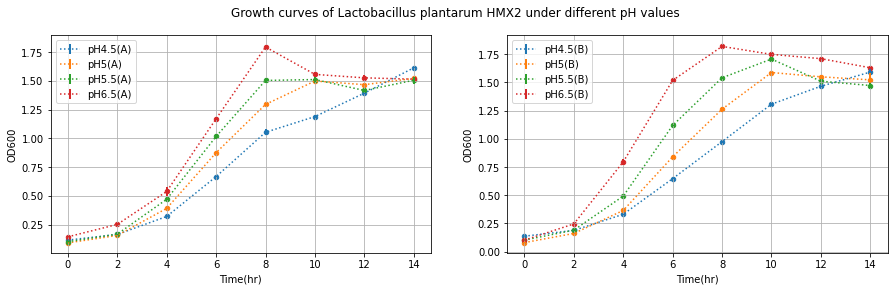

In [52]:
fig, axs = plt.subplots(1,2,figsize=(15,4))
times = np.arange(0,16,2)
for x in [4.5, 5, 5.5, 6.5]:
    temp_pd = (growth_A[growth_A['pH']==x]).reset_index().drop(['index'],axis=1)
    y = np.mean( temp_pd.iloc[:,2:5].values, axis=1)
    yerr = np.std( temp_pd.iloc[:,2:5].values, axis=1)
    axs[0].errorbar( times, y, yerr=yerr, linestyle='dotted', elinewidth=2, label='pH'+str(x)+'(A)')
    axs[0].scatter(times, y,s=20)

for x in [4.5, 5, 5.5, 6.5]:
    temp_pd = (growth_B[growth_B['pH']==x]).reset_index().drop(['index'],axis=1)
    y = np.mean( temp_pd.iloc[:,2:5].values, axis=1)
    yerr = np.std( temp_pd.iloc[:,2:5].values, axis=1)
    axs[1].errorbar( times, y, yerr=yerr, linestyle='dotted', elinewidth=2, label='pH'+str(x)+'(B)')
    axs[1].scatter(times, y,s=20)
for ax in axs:
    ax.legend()
    ax.grid()
    ax.set_xlabel('Time(hr)')
    ax.set_ylabel('OD600')
plt.suptitle('Growth curves of Lactobacillus plantarum HMX2 under different pH values')

In [15]:
def get_grs(od_list, time_step):
    output = []
    for i in range(len(od_list)-1):
        output.append( (np.log(od_list[i+1])-np.log(od_list[i]) )/time_step )
    return output  

Text(0.5, 0.98, 'Growth rates of Lactobacillus plantarum HMX2 under different pH values')

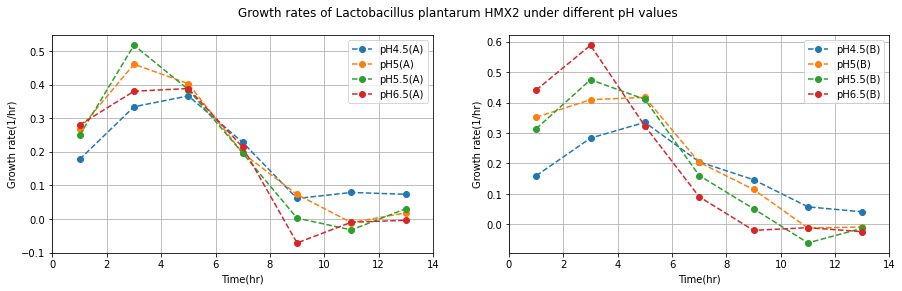

In [66]:
fig, axs = plt.subplots(1,2,figsize=(15,4))
times = np.arange(1,15,2)
for x in [4.5, 5, 5.5, 6.5]:
    temp_pd = (growth_A[growth_A['pH']==x]).reset_index().drop(['index'],axis=1)
    y = np.mean( temp_pd.iloc[:,2:5].values, axis=1)
    grs = get_grs(y, 2)
    axs[0].plot(times, grs, marker='o', linestyle='--', label='pH'+str(x)+'(A)')
for x in [4.5, 5, 5.5, 6.5]:
    temp_pd = (growth_B[growth_B['pH']==x]).reset_index().drop(['index'],axis=1)
    y = np.mean( temp_pd.iloc[:,2:5].values, axis=1)
    grs = get_grs(y, 2)
    axs[1].plot(times, grs, marker='o', linestyle='--', label='pH'+str(x)+'(B)')
for ax in axs:
    ax.legend()
    ax.grid()
    ax.set_xlabel('Time(hr)')
    ax.set_ylabel('Growth rate(1/hr)')
    ax.set_xticks(np.arange(0,16,2))
plt.suptitle('Growth rates of Lactobacillus plantarum HMX2 under different pH values')

In [12]:
def norm_rates(biomass, eps, time_step):
    output = []
    for i in range(len(biomass)-1):
        output.append( ((eps[i+1]-eps[i])/(biomass[i]/2+biomass[i+1]/2) )/time_step )
    return output

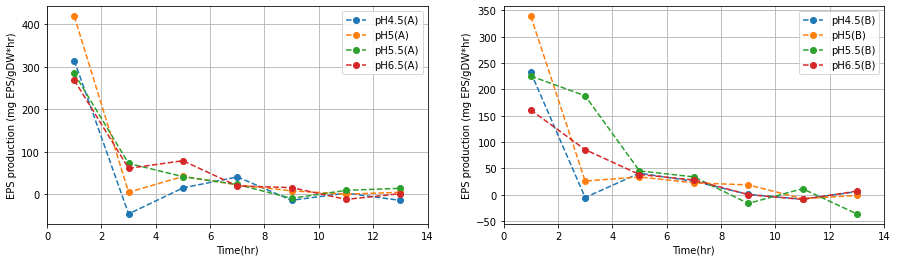

In [20]:
conv_factor = 0.35 # gDW/L : OD600 Reference:  https://doi.org/10.1111/j.1472-765X.2009.02752.x
fig, axs = plt.subplots(1,2,figsize=(15,4))
times = np.arange(1,15,2)
for x in [4.5, 5, 5.5, 6.5]:
    temp_pd = (growth_A[growth_A['pH']==x]).reset_index().drop(['index'],axis=1)
    biomass = np.mean( temp_pd.iloc[:,2:5].values, axis=1) * conv_factor
    eps = np.mean( temp_pd.iloc[:,5:].values, axis=1)
    eps_rates = norm_rates(biomass, eps, 2)
    axs[0].plot(times, eps_rates, marker='o', linestyle='--', label='pH'+str(x)+'(A)')
    
for x in [4.5, 5, 5.5, 6.5]:
    temp_pd = (growth_B[growth_B['pH']==x]).reset_index().drop(['index'],axis=1)
    biomass = np.mean( temp_pd.iloc[:,2:5].values, axis=1) * conv_factor
    eps = np.mean( temp_pd.iloc[:,5:].values, axis=1)
    eps_rates = norm_rates(biomass, eps, 2)
    axs[1].plot(times, eps_rates, marker='o', linestyle='--', label='pH'+str(x)+'(B)')
for ax in axs:
    ax.set_xticks(np.arange(0,16,2))
    ax.legend()
    ax.grid()
    ax.set_xlabel('Time(hr)')
    ax.set_ylabel('EPS production (mg EPS/gDW*hr)')

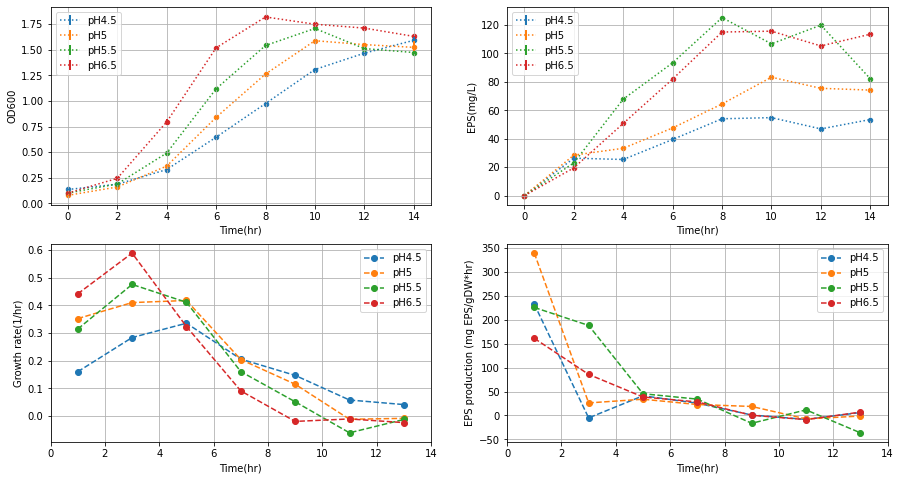

In [21]:
# Only use data from batch B
fig, axs = plt.subplots(2,2, figsize=(15,8))
for x in [4.5, 5, 5.5, 6.5]:
    temp_pd = (growth_B[growth_B['pH']==x]).reset_index().drop(['index'],axis=1)
    od = np.mean( temp_pd.iloc[:,2:5].values, axis=1)
    od_err = np.std( temp_pd.iloc[:,2:5].values, axis=1)
    grs = get_grs(od, 2)
    biomass = np.mean( temp_pd.iloc[:,2:5].values, axis=1) * conv_factor
    eps = np.mean( temp_pd.iloc[:,5:].values, axis=1)
    eps_err = np.std( temp_pd.iloc[:,5:].values, axis=1)
    eps_rates = norm_rates(biomass, eps, 2)
    
    axs[0][0].errorbar( np.arange(0,16,2), od, yerr= od_err, linestyle='dotted', elinewidth=2, label='pH'+str(x) )
    axs[0][0].scatter(np.arange(0,16,2), od,s=20)
    axs[0][0].set_ylabel('OD600')
    axs[0][1].errorbar( np.arange(0,16,2), eps, yerr= eps_err, linestyle='dotted', elinewidth=2, label='pH'+str(x) )
    axs[0][1].scatter(np.arange(0,16,2), eps,s=20)
    axs[0][1].set_ylabel('EPS(mg/L)')
    axs[1][0].plot( np.arange(1,15,2), grs, marker='o', linestyle='--', label='pH'+str(x))
    axs[1][0].set_ylabel('Growth rate(1/hr)')
    axs[1][1].plot( np.arange(1,15,2), eps_rates, marker='o', linestyle='--', label='pH'+str(x) )
    axs[1][1].set_ylabel('EPS production (mg EPS/gDW*hr)')
    
    for i in range(2):
        for j in range(2):
            axs[i][j].legend(); axs[i][j].set_xlabel('Time(hr)');
            axs[i][j].set_xticks(np.arange(0,16,2))
            axs[i][j].grid(visible=True)

# Pre-experiment: growth with pH control

In [3]:
growth_data = (pd.read_csv('../data/Exp_data/GrowthpHcontrol_pre.csv')).dropna()
growth_data = growth_data.drop(['Time'],axis=1)
timepts, samples, od600 = [],[],[]
for i in range(len(growth_data.columns)):
    for j in range(len(growth_data.index)):
        samples.append( growth_data.columns[i].split('_')[0].strip() )
        timepts.append( int(j) )
        od600.append( growth_data.iloc[j][i] )
temp_pd = pd.DataFrame(zip(timepts, samples, od600),columns=['Time','Sample','OD600'])

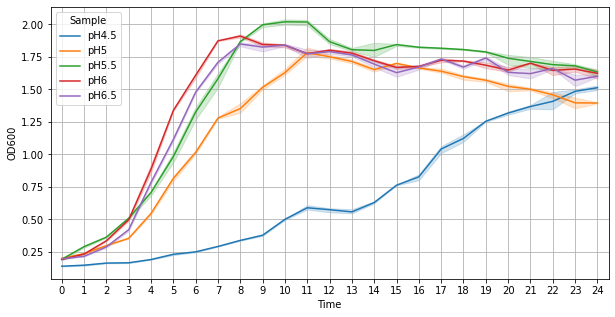

In [4]:
fig,ax = plt.subplots(figsize=(10,5))
sns.lineplot(x="Time", y="OD600",
             hue="Sample", 
             data=temp_pd,ax=ax)
ax.set_xticks(np.arange(0,25));
ax.set_xlim([-0.5,24.5])
ax.grid()

# Process proteomics dataset

In [4]:
def save_clean_fasta( in_path, out_path ):
    temp_records = SeqIO.parse( in_path , "fasta")
    new_records = []
    for seq_record in temp_records:
        ID = str(seq_record.id).split('|')[1].strip()
        seq = str(seq_record.seq)
        new_records.append( SeqRecord(Seq(seq), id = ID, name="",description="") )
    SeqIO.write(new_records, out_path ,"fasta")
    print( len(new_records) )

In [5]:
save_clean_fasta( '../data/Proteomics/uniprotkb_taxonomy_id_220668.fasta', '../data/Proteomics/wcfs1_prot.fasta' )

3088


In [2]:
proA, proB = pd.read_excel('../data/Proteomics/Proteomics_A.xlsx'), pd.read_excel('../data/Proteomics/Proteomics_B.xlsx') 
proA = proA[ ['Accession'] + list(proA.columns[-12:])].fillna(0)
proB = proB[ ['Accession'] + list(proB.columns[-12:])].fillna(0)
proA = proA.rename(columns={"Accession": "ID"})
proB = proB.rename(columns={"Accession": "ID"})

In [3]:
proAB = proA.merge(proB, left_on=['ID'], right_on= ['ID'],how='inner')
# proAB.to_csv('../data/Proteomics/Proteomics_AB.csv',index=None)

In [5]:
X = (proAB.iloc[:,1:].values).T
Xstd = StandardScaler().fit_transform(X)
pca_transform = PCA(n_components=2)
X_pca = pca_transform.fit_transform( Xstd )

In [6]:
print(pca_transform.explained_variance_ratio_)

[0.52181875 0.19651578]


In [7]:
samples = list( proAB.columns[1:] )
X_pca_pd = pd.DataFrame(X_pca, columns=['PC1(52.1%)','PC2(19.6%)'])
X_pca_pd['Batch'] = [x.split('-')[1][0] for x in samples]
X_pca_pd['Condition'] = [x.split('-')[0] for x in samples]

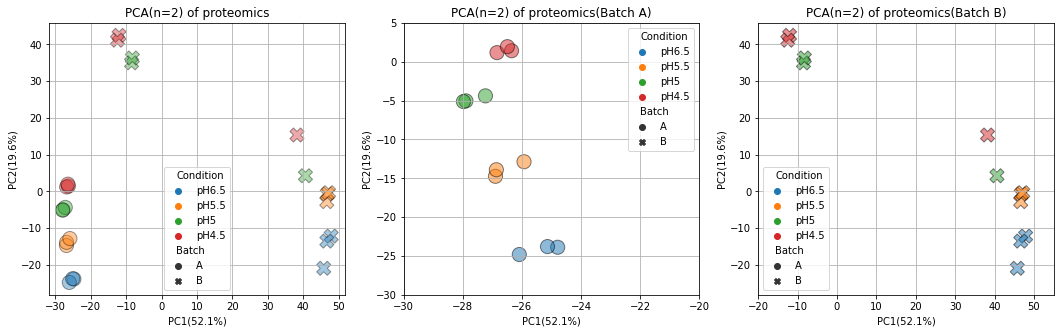

In [8]:
fig, axs = plt.subplots(1,3,figsize=(18,5))
sns.scatterplot(data=X_pca_pd, x="PC1(52.1%)", y="PC2(19.6%)", hue="Condition", style="Batch",\
                s=200,linewidth=1,alpha=0.4, edgecolor='black',ax= axs[0] )
sns.scatterplot(data=X_pca_pd, x="PC1(52.1%)", y="PC2(19.6%)", hue="Condition", style="Batch",\
                s=200,linewidth=1,alpha=0.5, edgecolor='black',ax= axs[1] )
sns.scatterplot(data=X_pca_pd, x="PC1(52.1%)", y="PC2(19.6%)", hue="Condition", style="Batch",\
                s=200,linewidth=1,alpha=0.5, edgecolor='black',ax= axs[2] )
axs[1].set_ylim([-30,5])
axs[1].set_xlim([-30,-20])
axs[2].set_xlim([-20,55])
axs[0].set_title('PCA(n=2) of proteomics')
axs[1].set_title('PCA(n=2) of proteomics(Batch A)')
axs[2].set_title('PCA(n=2) of proteomics(Batch B)')
for ax in axs:
    ax.grid()

# EPS composition

In [12]:
mw = {'Man':180.156,'GlcN':179.17 ,'Glc':180.156,'Gal':180.156,'GalA': 194.139, 'Ara': 150.13}
sugars = {'Man':176.719,'GlcN':22.150 ,'Glc':161.737,'Gal':33.919,'GalA': 0.697, 'Ara': 0.153 }
sugars_mol = {g: sugars[g]/mw[g] for g in mw.keys()}
total = sum( sugars_mol.values() )
sugars_molfrac = {g: sugars_mol[g]/total for g in sugars_mol.keys()}

links = {'t-Manp':36.055,'1,2,6-Manp':15.474,'1,2-Manp':14.888, 't-Glcp':13.867,'1,4-Galp':4.622,
        '1,4-Glcp':4.404, '1,6-Glcp':3.759,'1,3-Glcp':3.676,'t-Galp':1.150}
links['Others'] = 100-sum( links.values() )

Text(0.5, 1.0, 'Molar fraction of glycosidic linkages in EPS')

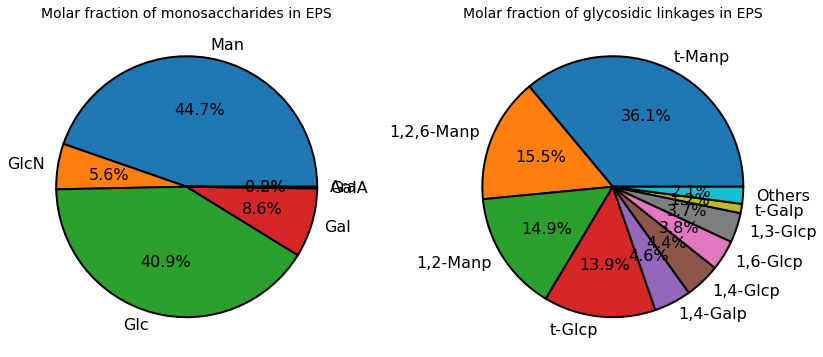

In [18]:
fig, axs = plt.subplots(1,2, figsize=(14,6))
axs[0].pie(sugars_molfrac.values(), labels=sugars_molfrac.keys(), autopct='%1.1f%%',
       wedgeprops = {"edgecolor" : "black",'linewidth': 2,'antialiased': True},
      textprops={'fontsize':16});
axs[0].set_title('Molar fraction of monosaccharides in EPS', fontsize=14)
axs[1].pie(links.values(), labels=links.keys(), autopct='%1.1f%%',
         wedgeprops = {"edgecolor" : "black",'linewidth': 2,'antialiased': True},
          textprops={'fontsize':16});
axs[1].set_title('Molar fraction of glycosidic linkages in EPS', fontsize=14)